In [1]:
%matplotlib inline


# Warm Starting from a Previously Trained Mixture of Gaussians

Here, we show how to "warm start" from an existing model.

This may be useful for several situations, such as:

* An "online" setting, where you have gained some additional data, and wish to apply a previous model without starting from scratch.

* You wish to take a previous run which might not have converged and train for several more laps (aka epochs or passes thru full data).

* You wish to try a slightly different model (alternative prior hyperparameters, etc.) or a slightly different algorithm, and see if the previously discovered solution is still preferred.

The existing model should be saved on disk, in BNPy format.

Any previous call to bnpy.run that specifies a valid output_path
will produce a file of the required format. 

The key idea to warm starting with BNPy is that you can specify the
full path of the desired previous training run 
as the "initname" keyword argument when you call bnpy.run:

    bnpy.run(..., initname='/path/to/previous_training_output/', ...)


In [1]:
# SPECIFY WHICH PLOT CREATED BY THIS SCRIPT IS THE THUMBNAIL IMAGE
# sphinx_gallery_thumbnail_number = 4

import bnpy
import numpy as np
import os

from matplotlib import pylab
import seaborn as sns

FIG_SIZE = (3, 3)
pylab.rcParams['figure.figsize'] = FIG_SIZE

Read bnpy's built-in "AsteriskK8" dataset from file.

5000 examples, each one a 2D point



In [2]:
dataset_path = os.path.join(bnpy.DATASET_PATH, 'AsteriskK8')
dataset = bnpy.data.XData.read_npz(
    os.path.join(dataset_path, 'x_dataset.npz'))

Make a simple plot of the raw data



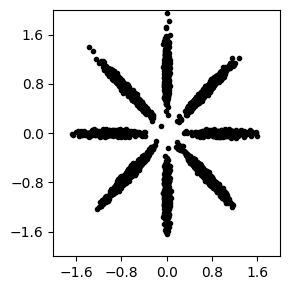

In [3]:
pylab.figure()
pylab.plot(dataset.X[:, 0], dataset.X[:, 1], 'k.')
pylab.gca().set_xlim([-2, 2])
pylab.gca().set_ylim([-2, 2])
pylab.tight_layout()

## Cold-start model training
Let's do one single run of the VB algorithm.

Using 10 clusters and the 'randexamples' initialization procedure.



In [23]:
cold_start_model, cold_info_dict = bnpy.run(
    dataset, 'FiniteMixtureModel', 'Gauss', 'VB',
    output_path='/tmp/AsteriskK8/coldstart-K=10/',
    nLap=25,
    sF=0.1, ECovMat='eye',
    K=10,
    initname='randexamples')

Dataset Summary:
X Data
  num examples: 5000
  num dims: 2
Allocation Model:  Finite mixture model. Dir prior param 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = randexamples
  K = 10 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: VB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/AsteriskK8/coldstart-K=10/1
        1/25 after      0 sec. |    201.4 MiB | K   10 | loss  6.582634775e-01 |  
        2/25 after      0 sec. |    201.4 MiB | K   10 | loss  4.350235353e-01 | Ndiff   68.926 
        3/25 after      0 sec. |    201.4 MiB | K   10 | loss  3.454096950e-01 | Ndiff  193.565 
        4/25 after      0 sec. |    201.4 MiB | K   10 | loss  3.049230819e-01 | Ndiff  175.237 
        5/25 after      0 sec. |    201.4 MiB | K   10 | loss  2.73243910

## Setup helper method to visualize clusters
Here's a short function to show how clusters evolve during training.



In [14]:
def show_clusters_over_time(
        task_output_path=None,
        query_laps=[0, 1, 2, 5, 10, None],
        nrows=2):
    ''' Read model snapshots from provided folder and make visualizations

    Post Condition
    --------------
    New matplotlib plot with some nice pictures.
    '''
    ncols = int(np.ceil(len(query_laps) // float(nrows)))
    fig_handle, ax_handle_list = pylab.subplots(
        figsize=(FIG_SIZE[0] * ncols, FIG_SIZE[1] * nrows),
        nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    for plot_id, lap_val in enumerate(query_laps):
        cur_model, lap_val = bnpy.load_model_at_lap(task_output_path, lap_val)
        # Plot the current model
        cur_ax_handle = ax_handle_list.flatten()[plot_id]
        bnpy.viz.PlotComps.plotCompsFromHModel(
            cur_model, Data=dataset, ax_handle=cur_ax_handle)
        cur_ax_handle.set_xticks([-2, -1, 0, 1, 2])
        cur_ax_handle.set_yticks([-2, -1, 0, 1, 2])
        cur_ax_handle.set_xlabel("lap: %d" % lap_val)
        cur_ax_handle.set_xlim([-2, 2])
        cur_ax_handle.set_ylim([-2, 2])
    pylab.tight_layout()

## Visualize cold start
Show the estimated clusters throughout training from cold



SKIPPED 1 comps with size below 0.00


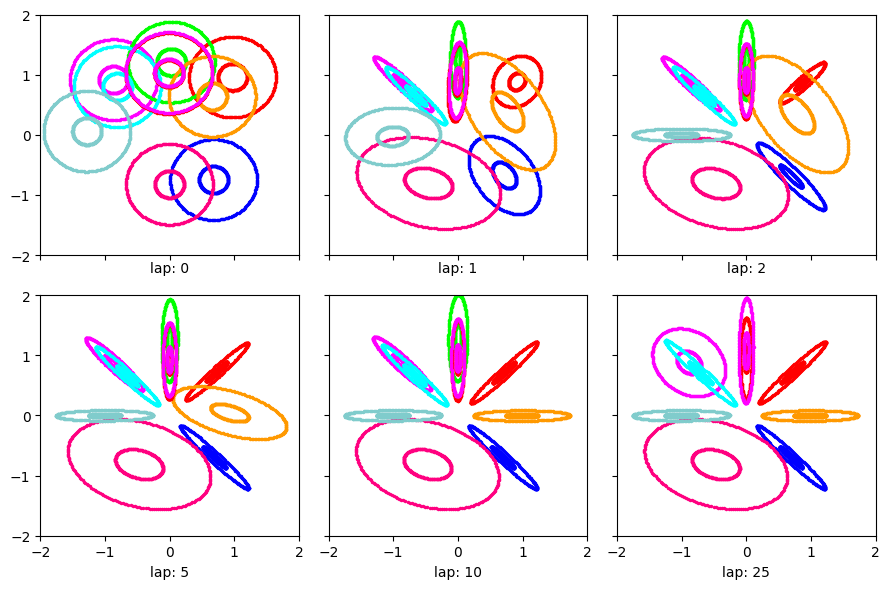

In [24]:
show_clusters_over_time(cold_info_dict['task_output_path'])

## Warm-start model training
Let's now do a warm-started single run of the VB algorithm.

We'll apply the same data and the same prior hyperparameters.

Using the previous cold-start training's final model,
as saved in its task_output_path.

Remember that the cold-start training saves its final model 
in directory specified by `cold_info_dict['task_output_path']`



In [25]:
warm_start_model, warm_info_dict = bnpy.run(
    dataset, 'FiniteMixtureModel', 'Gauss', 'VB',
    output_path='/tmp/AsteriskK8/warmstart-K=10/',
    nLap=100,
    sF=0.1, ECovMat='eye',
    # initname=cold_info_dict['task_output_path']
    initname = '/tmp/AsteriskK8/coldstart-K=10/1'
    )

Dataset Summary:
X Data
  num examples: 5000
  num dims: 2
Allocation Model:  Finite mixture model. Dir prior param 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = /tmp/AsteriskK8/coldstart-K=10/1
  K = 6 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: VB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: ../tmp/AsteriskK8/warmstart-K=10/1
        1/100 after      0 sec. |    207.1 MiB | K   10 | loss  1.982035545e-01 |  
        2/100 after      0 sec. |    207.1 MiB | K   10 | loss  1.974254707e-01 | Ndiff   10.598 
        3/100 after      0 sec. |    207.1 MiB | K   10 | loss  1.966834121e-01 | Ndiff   11.131 
        4/100 after      0 sec. |    207.1 MiB | K   10 | loss  1.964267444e-01 | Ndiff   11.549 
        5/100 after      0 sec. |    207.1 MiB |

## Visualize warm start
Show the estimated clusters throughout training from warm

We'll see that not much changes (since the init was already pretty good)



SKIPPED 1 comps with size below 0.00
SKIPPED 1 comps with size below 0.00
SKIPPED 2 comps with size below 0.00
SKIPPED 2 comps with size below 0.00
SKIPPED 2 comps with size below 0.00
SKIPPED 3 comps with size below 0.00


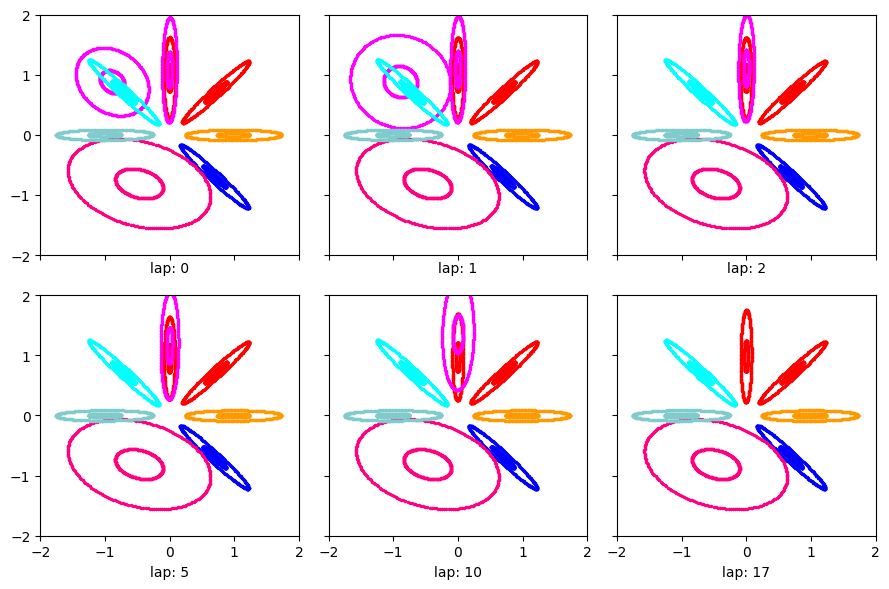

In [26]:
show_clusters_over_time(warm_info_dict['task_output_path'])

## Warm-start with different algorithm
We can apply a different algorithm to the same warm initialization.

Here, we'll do stochastic VB (soVB)
which divides the data into 100 batches at random (each ~50 examples)
and processes one batch at a time
with learning rate **rho** that decays with step t as:

   rho(t) <- (1 + t)^(-0.55)





In [27]:
warm_stoch_model, warm_stoch_info_dict = bnpy.run(
    dataset, 'FiniteMixtureModel', 'Gauss', 'soVB',
    output_path='/tmp/AsteriskK8/warmstart-K=10-alg=soVB/',
    nLap=5, nTask=1, nBatch=500,
    rhoexp=0.55, rhodelay=1,
    sF=0.1, ECovMat='eye',
    initname=cold_info_dict['task_output_path'],
    )

Dataset Summary:
X Data
  total size: 5000 units
  batch size: 10 units
  num. batches: 500
Allocation Model:  Finite mixture model. Dir prior param 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = /tmp/AsteriskK8/coldstart-K=10/1
  K = 6 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: soVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/AsteriskK8/warmstart-K=10-alg=soVB/1
    0.002/5 after      0 sec. |    211.1 MiB | K   10 | loss  3.858767609e+01 |  lrate 0.6830
    0.004/5 after      0 sec. |    211.1 MiB | K   10 | loss  2.242266228e+01 |  lrate 0.5465
    0.006/5 after      0 sec. |    211.1 MiB | K   10 | loss  1.622381779e+01 |  lrate 0.4665
    1.000/5 after      4 sec. |    212.1 MiB | K   10 | loss  1.109950213e+01 |  lrate 0.0327
    2.00

## Visualize stochastic VB from a warm start
Show the estimated clusters throughout training from warm



SKIPPED 1 comps with size below 0.00
SKIPPED 3 comps with size below 0.00
SKIPPED 3 comps with size below 0.00
SKIPPED 3 comps with size below 0.00
SKIPPED 3 comps with size below 0.00
SKIPPED 3 comps with size below 0.00


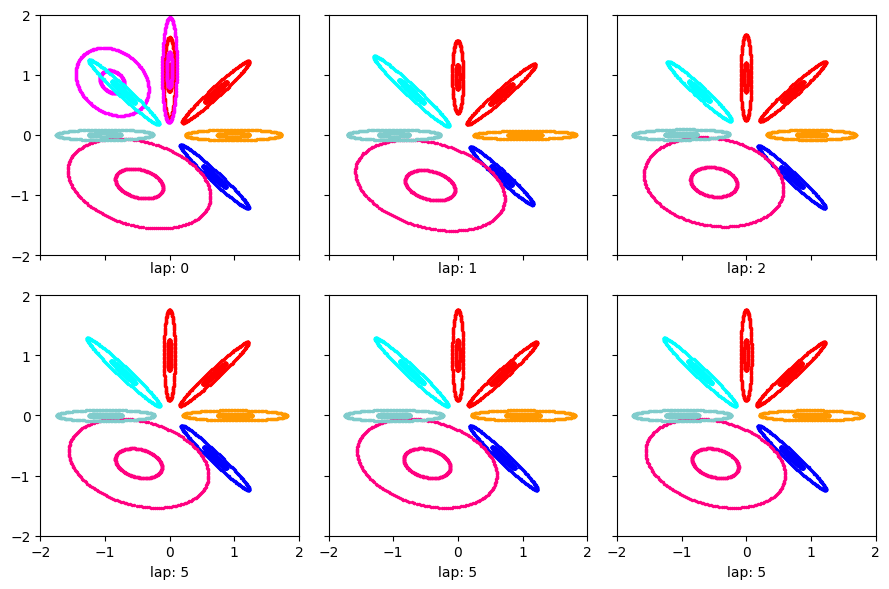

In [28]:
show_clusters_over_time(warm_stoch_info_dict['task_output_path'])

## Warm-start with different model: DP mixture model
We can apply a different model to the same warm initialization.

Here, we'll apply a Dirichlet Process (DP) mixture model
and use the memoized VB algorithm with birth and merge proposals.




In [12]:
warm_proposals_model, warm_proposals_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path='/tmp/AsteriskK8/warmstart-dp_mix-alg=memo_birth_merge/',
    nLap=100, nTask=1, nBatch=1,
    sF=0.1, ECovMat='eye',
    initname=cold_info_dict['task_output_path'],
    moves='birth,merge,shuffle',
    m_startLap=5, b_startLap=2, b_Kfresh=4)

Dataset Summary:
X Data
  total size: 5000 units
  batch size: 5000 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = /tmp/AsteriskK8/coldstart-K=10/1
  K = 6 (number of clusters)
  seed = 1607680
  elapsed_time: 0.1 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/AsteriskK8/warmstart-dp_mix-alg=memo_birth_merge/1
BIRTH @ lap 1.00: Disabled. Waiting for lap >= 2 (--b_startLap).
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    1.000/100 after      0 sec. |    200.2 MiB | K   10 | loss  1.965595456e-01 |  
MERGE @ lap 2.00: Disabled. Waiting for lap >= 5 (--m_startLap).
BIRTH @ lap 2.00 : Added 4 states. 1/8 succee

## Visualize warm start with proposals



SKIPPED 1 comps with size below 0.00
SKIPPED 3 comps with size below 0.00
SKIPPED 1 comps with size below 0.00


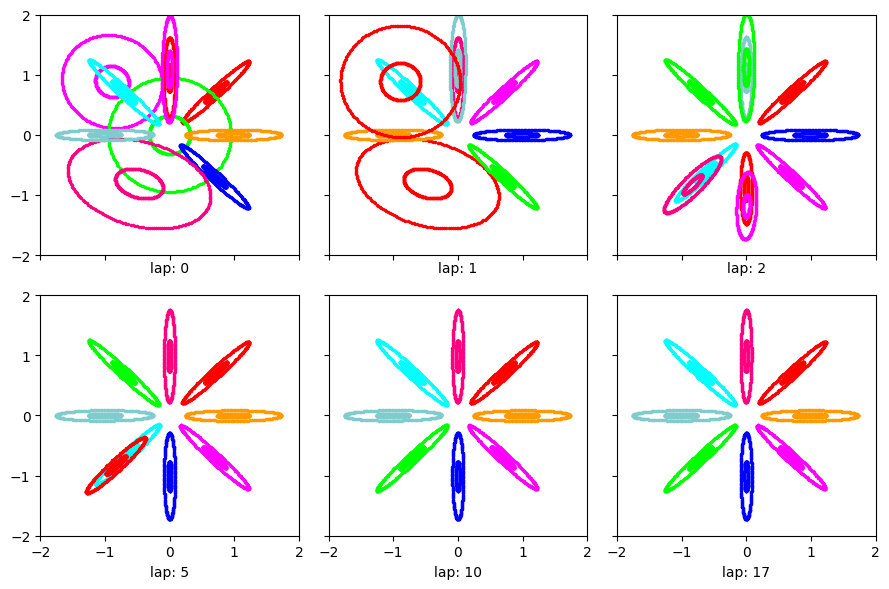

In [13]:
show_clusters_over_time(warm_proposals_info_dict['task_output_path'])

## Incorporating additional data
Suppose we were to observe a few new examples (shown in red)
in addition to the original data




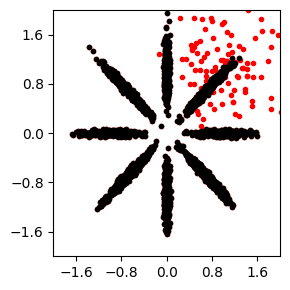

In [14]:
rng = np.random.RandomState(0)
new_x = rng.multivariate_normal(
    [1.0, 1.0],
    0.2 * np.eye(2),
    size=100)
combined_dataset = bnpy.data.XData(np.vstack([dataset.X, new_x]))

pylab.figure()
pylab.plot(combined_dataset.X[:, 0], combined_dataset.X[:, 1], 'r.')
pylab.plot(dataset.X[:, 0], dataset.X[:, 1], 'k.')
pylab.gca().set_xlim([-2, 2])
pylab.gca().set_ylim([-2, 2])
pylab.tight_layout()

## Warm-start with additional data
We can initialize from previous "warm started" DP mixture model
and apply this model to our expanded dataset.
We should see that it discovers an additional cluster of red
examples in the upper right quadrant.




In [15]:
extra_data_proposals_model, extra_data_proposals_info_dict = bnpy.run(
    combined_dataset, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path='/tmp/AsteriskK8_with_extra/warmstart-dp_mix-alg=memo_birth_merge/',
    nLap=100, nTask=1, nBatch=1,
    sF=0.1, ECovMat='eye',
    initname=warm_proposals_info_dict['task_output_path'],
    moves='birth,merge,shuffle',
    m_startLap=5, b_startLap=0, b_Kfresh=4)

Dataset Summary:
X Data
  total size: 5100 units
  batch size: 5100 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[0.1 0. ]
   [0.  0.1]]
Initialization:
  initname = /tmp/AsteriskK8/warmstart-dp_mix-alg=memo_birth_merge/1
  K = 6 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/AsteriskK8_with_extra/warmstart-dp_mix-alg=memo_birth_merge/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
BIRTH @ lap 1.00 : Added 12 states. 3/8 succeeded. 5/8 failed eval phase. 0/8 failed build phase.
    1.000/100 after      1 sec. |    200.2 MiB | K   20 | loss  6.188952141e-02 |  
MERGE @ lap 2.00: Disabled. Waiting for lap

## Visualize clusters discovered on expanded dataset



SKIPPED 3 comps with size below 0.00
SKIPPED 3 comps with size below 0.00
SKIPPED 1 comps with size below 0.00


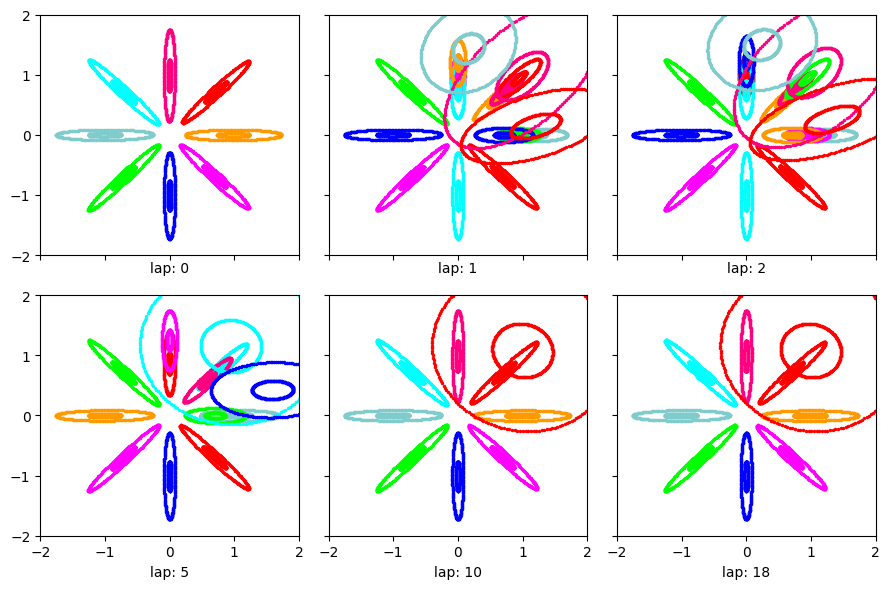

In [16]:
show_clusters_over_time(extra_data_proposals_info_dict['task_output_path'])